In [1]:
import healpy as hp 
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2
from taunet.simulation import CMBmap, FGMap, SkySimulation,CMBspectra,MakeSims

In [3]:
main_dir = '/marconi/home/userexternal/aidicher/storage/TAUNET'
paramdir = '/marconi/home/userexternal/aidicher/workspace/taunet/taunet/template_fitting'

In [6]:
m =MakeSims(main_dir,noise_g=True,nsim=50,ssim=0)

Saved power spectra


Generating 353 GHz maps: 100%|██████████| 50/50 [00:00<00:00, 4626.31sim/s]

Generating noise covariance matrices: NoiseModelGaussian


In [37]:
band = 143

In [38]:
m.make_params(band,paramdir)
m.job_file(band, paramdir)

In [39]:
m.submit_job(band,paramdir)

Submitted batch job 12788239


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


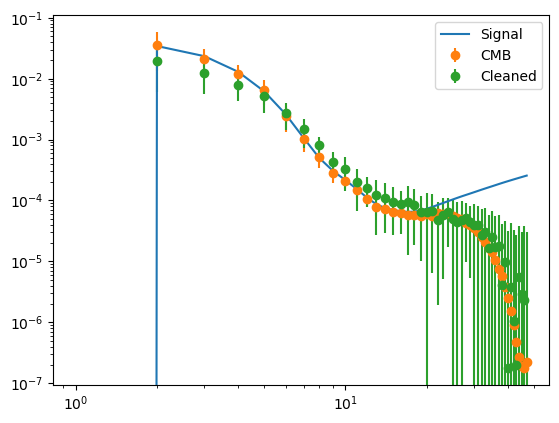

In [7]:
m.plot_cleaned(50)

NameError: name 'spectra_dir' is not defined

In [11]:
m =MakeSims(main_dir,noise_g=True)

Saved power spectra


Generating 353 GHz maps: 100%|██████████| 100/100 [00:00<00:00, 16867.63sim/s]

Generating noise covariance matrices: NoiseModelGaussian


In [10]:
m.make_params(143)

In [ ]:

spectra_dir = os.path.join(main_dir,'SPECTRA')
os.makedirs(spectra_dir,exist_ok=True)

In [4]:
nsim = 30
tau = 0.06
fg_model = ['s0','d0']

In [5]:
noise_levels = {
    '23': 65,
    '100': 55,
    '143': 60,
    '353': 65,
}

In [6]:
spectra = CMBspectra(tau=tau)
spectra.save_power(spectra_dir)

In [5]:
sky = SkySimulation(main_dir,nsim,tau,fg_model,cmb_const=False,noise_g=False)

In [15]:
hp.mollview(sky.QU(100,idx=3,unit='K',order='nested',beam=True)[2],nest=True)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [12]:
simdir = os.path.join(main_dir,'SIMULATIONS_'+''.join(fg_model))
os.makedirs(simdir,exist_ok=True)

In [13]:
for f in [23,100,143,353]:
    for i in range(nsim):
        if not os.path.isfile(os.path.join(simdir,f'sky_{f}_{i}.fits')):
            Q, U = sky.QU(f,idx=i,unit='K',order='nested')#,nlevp=noise_levels[str(f)])
            hp.write_map(os.path.join(simdir,f'sky_{f}_{i}.fits'),[Q*0,Q,U],nest=True,dtype=np.float64)

In [10]:
clean_dir = os.path.join(main_dir,'CLEAN')
os.makedirs(clean_dir,exist_ok=True)